##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [1]:
#%pip install pandas 
#%pip install matplotlib
#%pip install seaborn
#%pip install scikit-learn
#%pip install geopy
#%pip install category_encoders
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [2]:
# Can have as many cells as you want for code
filepath = "./data/catA_train.csv" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [3]:
###...code...###
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re
import sklearn
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from geopy.geocoders import Nominatim
import math
from category_encoders.binary import BinaryEncoder
import random
import string

# Data Cleaning

In [4]:
def get_random_string():
    return ''.join(random.choice(string.ascii_letters) for i in range(5))

def refreshLocator():
        return Nominatim(user_agent=get_random_string())

geolocator = refreshLocator()

def getCountry(lat, long):
    global geolocator
    if (math.isnan(lat) or math.isnan(long)): return "None"
    try:
        return geolocator \
            .reverse(f"{lat},{long}") \
            .raw['address'] \
            .get('country', '')
    except Exception:
        geolocator = refreshLocator()
        getCountry(lat, long)

In [5]:
# Overview
df_main = pd.read_csv(filepath, encoding='utf-8')
pd.set_option('display.max_columns', None)

# Note: all companies are active
# df_main['Company Status (Active/Inactive)'].unique()

# Fill NA
for empty_col in [
    { 'empty': 'Parent Company', 'replacement': 'Company' },
    { 'empty': 'Global Ultimate Company', 'replacement': 'Company' },
    { 'empty': 'Domestic Ultimate Company', 'replacement': 'Company' },
]:
    df_main[empty_col['empty']] = df_main[empty_col['empty']].fillna(df_main[empty_col['replacement']])

emp_regex = re.compile('^Employees')
for emp_col in [x for x in df_main.columns.values.tolist() if emp_regex.match(x)]:
    df_main[emp_col] = df_main[emp_col].fillna(0)

for empty_country in ['Parent Country', 'Global Ultimate Country']:
    df_main[empty_country] = df_main[empty_country].fillna(
        getCountry(df_main['LATITUDE'].iloc[0], df_main['LONGITUDE'].iloc[0])
    )

df_main['Import/Export Status'] = df_main['Import/Export Status'].fillna("None")
    
# Sum columns
df_main['Sales (Overall Ultimate Total USD)'] = df_main['Sales (Global Ultimate Total USD)'] + \
    df_main['Sales (Domestic Ultimate Total USD)']
df_main['Employees (Overall Ultimate Total)'] = df_main['Employees (Domestic Ultimate Total)'] + \
    df_main['Employees (Global Ultimate Total)']
    
# df_main.describe(include='all', datetime_is_numeric=True).transpose()
# df_main.dtypes
# df_main.isnull().any()
# df_main[df_main['Global Ultimate Company'].isnull()]

# Data Visualisation

## Sales

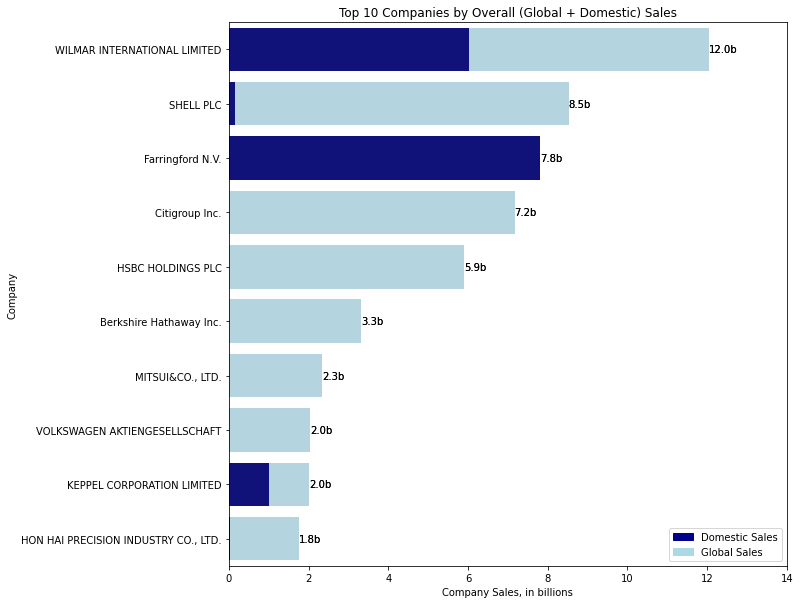

In [6]:
# Note: includes negative sales values
df_companies_sum = df_main \
    .groupby('Global Ultimate Company') \
    .sum() \
    .sort_values(by='Sales (Overall Ultimate Total USD)', ascending=False) \
    .reset_index()

plt.figure(figsize=(10, 10))
NUM_TOP = 10

graph_top = sns.barplot(
    x="Sales (Overall Ultimate Total USD)",
    y="Global Ultimate Company",
    data=df_companies_sum.head(NUM_TOP),
    color='lightblue'
)
graph_bottom = sns.barplot(
    x="Sales (Domestic Ultimate Total USD)",
    y="Global Ultimate Company",
    data=df_companies_sum.head(NUM_TOP),
    color='darkblue'
)

for graph in (graph_top, graph_bottom):
    graph.set_xticks(graph.get_xticks().tolist())
    graph.set_xticklabels(
        ['{:.0f}'.format(x) for x in graph.get_xticks()/1e12]
    )
    
    bars = graph.containers[0]
    graph.bar_label(
        bars,
        labels=[f"{value/1e12:.1f}b" for value in bars.datavalues]
    )

top_bar = mpatches.Patch(color='darkblue', label='Domestic Sales')
bottom_bar = mpatches.Patch(color='lightblue', label='Global Sales')
plt.xlabel("Company Sales, in billions")
plt.ylabel("Company")
plt.title(f"Top {NUM_TOP} Companies by Overall (Global + Domestic) Sales")
plt.legend(handles=[top_bar, bottom_bar])
plt.show()

## Employees

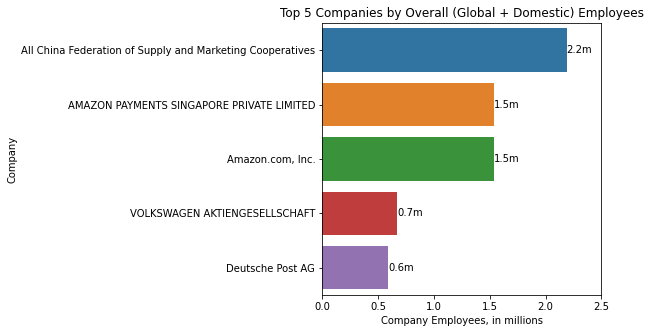

In [7]:
df_companies_avg = df_main \
    .groupby('Global Ultimate Company') \
    .mean() \
    .sort_values(by='Employees (Overall Ultimate Total)', ascending=False) \
    .reset_index() \
    [['Global Ultimate Company', 'Employees (Overall Ultimate Total)']]

plt.figure(figsize=(5, 5))
NUM_TOP = 5

g = sns.barplot(
    x="Employees (Overall Ultimate Total)",
    y="Global Ultimate Company",
    data=df_companies_avg.head(NUM_TOP),
)

g.set_xticks(g.get_xticks().tolist())
g.set_xticklabels(['{:.1f}'.format(x) for x in g.get_xticks()/1e6])

bars = g.containers[0]
g.bar_label(
    bars,
    labels=[f"{value/1e6:.1f}m" for value in bars.datavalues]
)

plt.xlabel("Company Employees, in millions")
plt.ylabel("Company")
plt.title(f"Top {NUM_TOP} Companies by Overall (Global + Domestic) Employees")
plt.show()

## Private vs Public

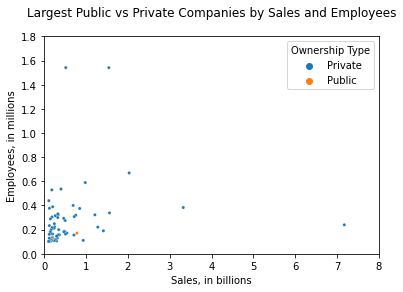

In [8]:
df_private_public = df_companies_sum[['Global Ultimate Company', 'Sales (Overall Ultimate Total USD)']] \
    .join(df_companies_avg.set_index('Global Ultimate Company'), on='Global Ultimate Company') \
    .join(
        df_main[['Global Ultimate Company', 'Ownership Type']].set_index('Global Ultimate Company'),
        on='Global Ultimate Company'
    ).drop_duplicates(subset='Global Ultimate Company')
df_private_public_top = df_private_public[
    (df_private_public['Sales (Overall Ultimate Total USD)'] >= 1e11) &
    (df_private_public['Employees (Overall Ultimate Total)'] >= 1e5)
]

g = sns.scatterplot(
    data=df_private_public_top, 
    x="Sales (Overall Ultimate Total USD)", 
    y="Employees (Overall Ultimate Total)", 
    hue="Ownership Type", 
    s=10
)

g.set_xticks(g.get_xticks().tolist())
g.set_xticklabels(['{:.0f}'.format(x) for x in g.get_xticks()/1e12])
g.set_yticks(g.get_yticks().tolist())
g.set_yticklabels(['{:.1f}'.format(x) for x in g.get_yticks()/1e6])

plt.gca().set_xlim(left=0)
plt.xlabel("Sales, in billions")
plt.ylabel("Employees, in millions")
g.set_title(f"Largest Public vs Private Companies by Sales and Employees", pad=20)
plt.show()

# Modelling

## Preprocessing

In [9]:
df_train = pd.DataFrame()

In [10]:
# Encode categorical data
encoders = {
    "ohe": {
        "enc": preprocessing.OneHotEncoder(),
        "cols": ['Entity Type', 'Ownership Type', 'Import/Export Status'],
    },
    "lb": {
        "enc": BinaryEncoder,
        "cols": [
            'Parent Company', 'Parent Country', 'Global Ultimate Company',
            'Global Ultimate Country', 'Domestic Ultimate Company'
        ],
    },
}

for name, encoder in encoders.items():
    if (name == "ohe"):
        encoder['enc'].fit(df_main[encoder['cols']])
        df_train = pd.DataFrame(
            encoder['enc'].transform(df_main[encoder['cols']]).toarray(),
            columns=encoder['enc'].get_feature_names()
        )
    elif (name == "lb"):
        encoder['enc'] = encoder['enc'](cols=encoder['cols'])
        df_train = pd.concat(
            [df_train, encoder['enc'].fit_transform(df_main[encoder['cols']])],
            axis=1
        )
df_train

,x0_Branch,x0_Independent,x0_Parent,x0_Subsidiary,x1_Non-Corporates,x1_Nonprofit,x1_Partnership,x1_Private,x1_Public,x1_Public Sector,x2_Both Imports & Exports,x2_Exports,x2_Imports,x2_None,Parent Company_0,Parent Company_1,Parent Company_2,Parent Company_3,Parent Company_4,Parent Company_5,Parent Company_6,Parent Company_7,Parent Company_8,Parent Company_9,Parent Company_10,Parent Company_11,Parent Company_12,Parent Company_13,Parent Company_14,Parent Country_0,Parent Country_1,Parent Country_2,Parent Country_3,Parent Country_4,Parent Country_5,Parent Country_6,Global Ultimate Company_0,Global Ultimate Company_1,Global Ultimate Company_2,Global Ultimate Company_3,Global Ultimate Company_4,Global Ultimate Company_5,Global Ultimate Company_6,Global Ultimate Company_7,Global Ultimate Company_8,Global Ultimate Company_9,Global Ultimate Company_10,Global Ultimate Company_11,Global Ultimate Company_12,Global Ultimate Company_13,Global Ultimate Country_0,Global Ultimate Country_1,Global Ultimate Country_2,Global Ultimate Country_3,Global Ultimate Country_4,Global Ultimate Country_5,Global Ultimate Country_6,Domestic Ultimate Company_0,Domestic Ultimate Company_1,Domestic Ultimate Company_2,Domestic Ultimate Company_3,Domestic Ultimate Company_4,Domestic Ultimate Company_5,Domestic Ultimate Company_6,Domestic Ultimate Company_7,Domestic Ultimate Company_8,Domestic Ultimate Company_9,Domestic Ultimate Company_10,Domestic Ultimate Company_11,Domestic Ultimate Company_12,Domestic Ultimate Company_13,Domestic Ultimate Company_14
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29177,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,1,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,0,0,1,1,0,0,0,0,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,0
29178,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,1,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0
29179,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,1,1,1,1,1,0,1,1,0,1,0,0,0,0,1,0,1,0,1,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1
29180,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,1,1,1,1,1,0,1,1,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0


## Feature Selection

In [11]:
# Note: predict using 'Company' rather than 'Global Ultimate Company'
df_main.columns
features = [
    'Company', 'SIC Code', 'Year Found',
    'Entity Type', 'Parent Company', 'Parent Country', 'Ownership Type', 'Employees (Single Site)',
    'Employees (Domestic Ultimate Total)', 'Employees (Global Ultimate Total)',
    'Sales (Domestic Ultimate Total USD)', 'Sales (Global Ultimate Total USD)', 'Import/Export Status',
    'Fiscal Year End', 'Global Ultimate Company', 'Global Ultimate Country',
    'Domestic Ultimate Company', 'Is Domestic Ultimate', 'Is Global Ultimate'
]

## Building the Model

In [12]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
iris

{'data':      sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0                  5.1               3.5                1.4               0.2
 1                  4.9               3.0                1.4               0.2
 2                  4.7               3.2                1.3               0.2
 3                  4.6               3.1                1.5               0.2
 4                  5.0               3.6                1.4               0.2
 ..                 ...               ...                ...               ...
 145                6.7               3.0                5.2               2.3
 146                6.3               2.5                5.0               1.9
 147                6.5               3.0                5.2               2.0
 148                6.2               3.4                5.4               2.3
 149                5.9               3.0                5.1               1.8
 
 [150 rows x 4 columns],
 'target': 0     

In [13]:
# splitting into train and test datasets

from sklearn.model_selection import train_test_split
datasets = train_test_split(iris.data, iris.target,
                            test_size=0.2)

train_data, test_data, train_labels, test_labels = datasets

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [14]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''

    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [15]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

[]


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!